In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/digipodium/Datasets/main/regression/house_pricing.csv")
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
df.nunique()

In [ ]:
sns.boxplot(data=df, x='City', y='Price')
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.boxplot(data=df, x='Type', y='Price')
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.boxplot(data=df, x='Beds', y='Price')
plt.show()

In [ ]:
sns.boxplot(data=df, x='Baths', y='Price')
plt.show()

<Axes: xlabel='SquareFeet', ylabel='Price'>

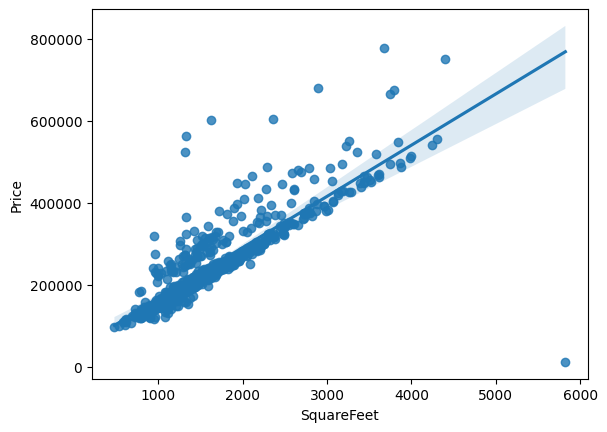

In [21]:
sns.regplot(data=df, x='SquareFeet', y='Price')

# pipeline

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [25]:
text_cols = ['Type']
num_cols = ['SquareFeet', 'Beds', 'Baths']

X = df[text_cols + num_cols]
y = df['Price']

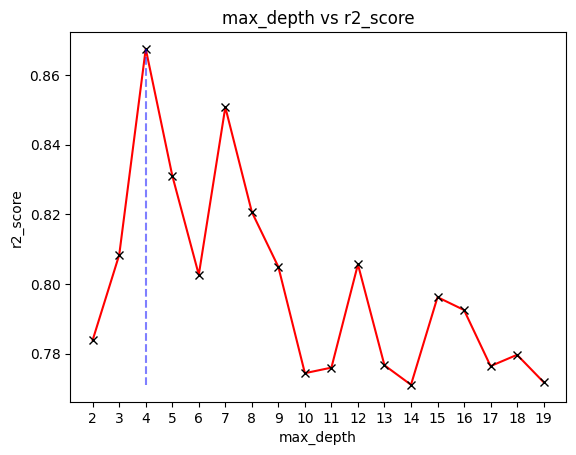

In [64]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, 
    test_size=0.2, 
    random_state=0)
cat_pipe = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])
num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, text_cols)
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('reg', DecisionTreeRegressor())
])
# max_depth
scores = []
for i in range(2, 20):
    model.named_steps['reg'].set_params(max_depth=i)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    scores.append(r2_score(ytest, ypred))
plt.plot(range(2, 20), scores, marker='x', color='red', markeredgecolor='black')
plt.vlines(x=4, ymin=min(scores), ymax=max(scores), color='blue', linestyle='--',
        alpha=0.5)
plt.title('max_depth vs r2_score')
plt.xlabel('max_depth')
plt.ylabel('r2_score')
plt.xticks(range(2, 20))
plt.show()

In [51]:
ypred = model.predict(Xtest)
print('R2:', r2_score(ytest, ypred))
print('MAE:', mean_absolute_error(ytest, ypred))
print('MSE:', mean_squared_error(ytest, ypred))

R2: 0.8310980989316616
MAE: 25878.513671538603
MSE: 1535642000.6647909
